In [2]:
import json
import os
import numpy
import pandas
import copy
import conntility, connalysis

from scipy.spatial import KDTree
from pnagm import util, nngraph, instance, test

from matplotlib import pyplot as plt



In [112]:
analze_direction = "incoming"

In [17]:
config_fn = "../configs/pnagm_L45E_microns_yscale_experimental_v1p5.json"
bin_sz = 20.0

with open(config_fn, "r") as fid:
    cfg = json.load(fid)

if "fn" in cfg["make_points"]:
    microns_fn = cfg["make_points"]["fn"]
    print("""
A reference connectome is expected at path {0},
          please place it there or update the path in the configuration file!
""".format(microns_fn))
    
    # For internal use only :)
    microns_connectome_prefix = "/Users/mwr/Documents/artefacts/connectomes"
    cfg["make_points"]["fn"] = os.path.join(microns_connectome_prefix, cfg["make_points"]["fn"])

pts, microns = util.points_from_microns(cfg["make_points"])
reference = microns.matrix > 0


A reference connectome is expected at path microns_mm3_connectome_v1181.h5,
          please place it there or update the path in the configuration file!

12881


In [7]:
M = microns.array.astype(bool)

In [ ]:
DD = test.DDtest(microns)

bin_centers = 0.5 * (test.dbins[1:] + test.dbins[:-1])

p = DD.for_matrix(reference)
logp = numpy.log(p)
valid = ~(numpy.isnan(logp) | numpy.isinf(logp))
f_params = numpy.polyfit(bin_centers[valid], logp[valid], 1)

a = numpy.exp(f_params[1])
b = -f_params[0]

ctrl_instance = connalysis.randomization.run_DD2(len(DD.m), a, b, DD.m.vertices[["x", "y", "z"]].values)
ctrl_instance = numpy.array(ctrl_instance.astype(bool).todense())

In [13]:
xyz = microns.vertices[["x", "y", "z"]].values

deltas = xyz.reshape((-1, 1, 3)) - xyz.reshape((1, -1, 3))
dy = deltas[:, :, 1]
dh = numpy.sqrt((deltas[:, :, [0, 2]] ** 2).sum(axis=2))

In [53]:
bins_y = numpy.arange(0, numpy.max(numpy.abs(dy)) + bin_sz, bin_sz)
bins_y = numpy.hstack([-bins_y[-1:0:-1], bins_y])
bin_idx_y = numpy.arange(len(bins_y))

bins_h = numpy.arange(0, numpy.max(dh) + bin_sz, bin_sz)
bin_idx_h = numpy.arange(len(bins_h))

Dy = numpy.digitize(dy, bins=bins_y)
numpy.fill_diagonal(Dy, -1)
Dh = numpy.digitize(dh, bins=bins_h)
numpy.fill_diagonal(Dh, -1)

In [113]:
tree = KDTree(xyz)

_, neigh_idx = tree.query(xyz, [2])
neigh_idx = neigh_idx[:, 0]

if analze_direction == "outgoing":
    # NN connectivity. Entry at i, j: Existence of a connection from i to the nearest neighbor of j
    Mneigh = M[:, neigh_idx]
    Ctrlneigh = ctrl_instance[:, neigh_idx]
elif analze_direction == "incoming":
    # NN connectivity. Entry at i, j: Existence of a connection from the nearest neighbor of i to j
    Mneigh = M[neigh_idx, :]
    Ctrlneigh = ctrl_instance[neigh_idx, :]
else:
    raise ValueError()



In [114]:
df = pandas.DataFrame({
    "dy": Dy.flatten(),
    "dh": Dh.flatten(),
    "M": M.flatten(),
    "Mneigh": Mneigh.flatten(),
    "C": ctrl_instance.flatten(),
    "Cneigh": Ctrlneigh.flatten()
})
df = df[df["dy"] > -1]

In [115]:
I = df.groupby(["dh", "dy"])["M"].mean()
counts = df.groupby(["dh", "dy"])["M"].count()
I[counts < 50] = numpy.nan

I = I.unstack("dh").reindex(index=bin_idx_y, columns=bin_idx_h)

Inn = df.groupby(["Mneigh", "dh", "dy"])["M"].mean()
counts = df.groupby(["Mneigh", "dh", "dy"])["M"].count()
Inn[counts < 50] = numpy.nan

Inn_con = Inn.loc[True].unstack("dh").reindex(index=bin_idx_y, columns=bin_idx_h)
Inn_uncon = Inn.loc[False].unstack("dh").reindex(index=bin_idx_y, columns=bin_idx_h)

In [116]:
J = df.groupby(["dh", "dy"])["C"].mean()
counts = df.groupby(["dh", "dy"])["C"].count()
J[counts < 50] = numpy.nan
J = J.unstack("dh").reindex(index=bin_idx_y, columns=bin_idx_h)

Jnn = df.groupby(["Cneigh", "dh", "dy"])["C"].mean()
counts = df.groupby(["Cneigh", "dh", "dy"])["C"].count()
Jnn[counts < 50] = numpy.nan

Jnn_con = Jnn.loc[True].unstack("dh").reindex(index=bin_idx_y, columns=bin_idx_h)
Jnn_uncon = Jnn.loc[False].unstack("dh").reindex(index=bin_idx_y, columns=bin_idx_h)

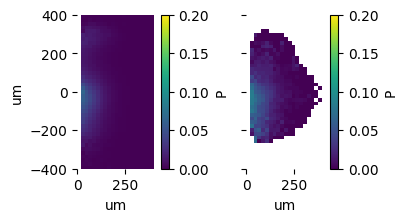

In [117]:
fig = plt.figure(figsize=(4, 2))
axes = fig.subplots(1, 2, sharex=True, sharey=True)
axes[0].set_xlim([0, 400]); axes[0].set_ylim([-400, 400])

ax = axes[0]
plt.colorbar(ax.imshow(I, clim=(0, 0.2),
           extent=(bins_h[0], bins_h[-1], bins_y[-1], bins_y[0])),
           label="P")
ax.set_frame_on(False)
ax.set_xlabel("um")
ax.set_ylabel("um")

ax = axes[1]
plt.colorbar(ax.imshow(Inn_con, clim=(0, 0.2),
           extent=(bins_h[0], bins_h[-1], bins_y[-1], bins_y[0])),
           label="P")
ax.set_frame_on(False)
ax.set_xlabel("um")

fig.savefig("plots_1/motivation_microns_data_{0}.pdf".format(analze_direction))

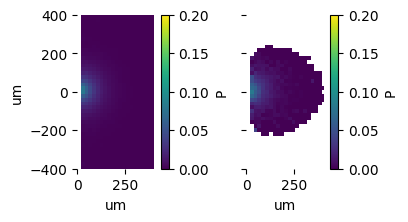

In [118]:
fig = plt.figure(figsize=(4, 2))
axes = fig.subplots(1, 2, sharex=True, sharey=True)
axes[0].set_xlim([0, 400]); axes[0].set_ylim([-400, 400])

ax = axes[0]
plt.colorbar(ax.imshow(J, clim=(0, 0.2),
           extent=(bins_h[0], bins_h[-1], bins_y[-1], bins_y[0])),
           label="P")
ax.set_frame_on(False)
ax.set_xlabel("um")
ax.set_ylabel("um")

ax = axes[1]
plt.colorbar(ax.imshow(Jnn_con, clim=(0, 0.2),
           extent=(bins_h[0], bins_h[-1], bins_y[-1], bins_y[0])),
           label="P")
ax.set_frame_on(False)
ax.set_xlabel("um")

fig.savefig("plots_1/motivation_dd_control_{0}.pdf".format(analze_direction))